In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from models import *

import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#device = 'cpu'
print(device)

cuda:0


In [3]:
#cifar_train = datasets.CIFAR10('./data', train=True, download=True, transform=transforms.ToTensor())
cifar_test = datasets.CIFAR10('./data', train=False, download=True, transform=transforms.ToTensor())

#train_loader = DataLoader(cifar_train, batch_size=128, shuffle=True)
test_loader = DataLoader(cifar_test, batch_size=128, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img_tensor):
    img = torchvision.utils.make_grid(img_tensor)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))
    plt.show

def show_labels(labels):
    print(' '.join('%5s' % classes[labels[j]] for j in range(labels.size()[0])))

Files already downloaded and verified


In [4]:
net = ResNet50()
PATH = './resnet50_adversarial_training.pth'
net.load_state_dict(torch.load(PATH))
net.to(device)
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (

In [5]:
print('Standard Test')

correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).double().sum().item()

        
print('Correct: ', int(correct), 'of', total)
print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Standard Test
Correct:  7982 of 10000
Accuracy of the network on the 10000 test images: 79 %


In [6]:
def fgsm(model, images, labels, epsilon):
    training =  model.training
    model.eval()
    delta = torch.zeros_like(images, requires_grad=True)
    loss = nn.CrossEntropyLoss()(model(images + delta), labels)
    loss.backward()
    perturbed_images = images + epsilon * delta.grad.detach().sign()
    perturbed_images = torch.clamp(perturbed_images, 0, 1)
    if training:
        model.train()
    return perturbed_images.detach()


def pgd(model, images, labels, epsilon, alpha=0.005, num_iter=20):
    training = model.training
    model.eval()
    delta = torch.zeros_like(images, requires_grad=True)
    for t in range(num_iter):
        loss = nn.CrossEntropyLoss()(model(images + delta), labels)
        loss.backward()
        delta.data = delta + alpha * delta.grad.detach().sign()
        delta.data = torch.clamp(delta, -epsilon, epsilon)
        delta.data = torch.max(torch.min(delta, 1 - images), -images)
        delta.grad.zero_()
    if training:
        model.train()
    return (images + delta).detach()

In [7]:
epsilons = [0, .01, .02, .03, .05]

In [8]:
def test(attack, model, device, test_loader, epsilon):
    correct = 0
    adv_examples = []
    
    
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        
        perturbed_images = attack(model, images, labels, epsilon)
        
        with torch.no_grad():
            outputs = model(perturbed_images.to(device))
        
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).double().sum().item()
            
            if (epsilon == 0) and (len(adv_examples) < 5):
                for i in range(images.size(0)):
                    adv_ex = perturbed_images[i,:,:,:].squeeze().detach().cpu().numpy()
                    adv_examples.append((labels[i].item(), predicted[i].item(), adv_ex))
                    if len(adv_examples) >= 5:
                        break
            else:
                if len(adv_examples) < 5:
                    for i in range(images.size(0)):
                        if predicted[i] != labels[i]:
                            adv_ex = perturbed_images[i,:,:,:].squeeze().detach().cpu().numpy()
                            adv_examples.append((labels[i].item(), predicted[i].item(), adv_ex))
                            if len(adv_examples) >= 5:
                                break
                                
                
    final_acc = correct/float(len(cifar_test)) * 100
    print('Epsilon: {}\tTest Accuracy = {} / {} = {} %'.format(epsilon, int(correct), len(cifar_test), final_acc))
    return final_acc, adv_examples

In [9]:
fgsm_accuracies = []
fgsm_examples = []

print('Fast Gradient Sign Method')

for eps in epsilons:
    acc, ex = test(fgsm, net, device, test_loader, eps)
    fgsm_accuracies.append(acc)
    fgsm_examples.append(ex)

Fast Gradient Sign Method
Epsilon: 0	Test Accuracy = 7982 / 10000 = 79.82000000000001 %
Epsilon: 0.01	Test Accuracy = 6689 / 10000 = 66.89 %
Epsilon: 0.02	Test Accuracy = 5542 / 10000 = 55.42 %
Epsilon: 0.03	Test Accuracy = 4694 / 10000 = 46.94 %
Epsilon: 0.05	Test Accuracy = 3772 / 10000 = 37.72 %


Fast Gradient Sign Method


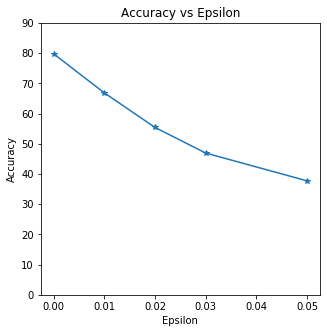

In [10]:
print('Fast Gradient Sign Method')

plt.figure(figsize=(5, 5))
plt.plot(epsilons, fgsm_accuracies, '*-')
plt.yticks(np.arange(0, 100, step=10))
plt.xticks(np.arange(0, .06, step=0.01))
plt.title('Accuracy vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.show()

Fast Gradient Sign Method


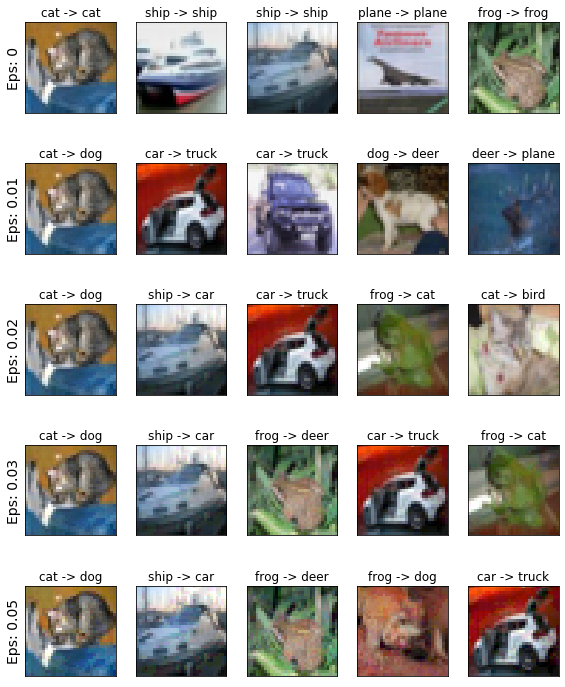

In [11]:
print('Fast Gradient Sign Method')

cnt = 0
plt.figure(figsize=(8, 10))
for i, eps in enumerate(epsilons):
    for j, exmps in enumerate(fgsm_examples[i]):
        cnt += 1
        plt.subplot(len(epsilons), len(fgsm_examples[0]), cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel('Eps: {}'.format(eps), fontsize=14)
        orig, adv, ex = exmps
        plt.title("{} -> {}".format(classes[orig], classes[adv]))
        plt.imshow(np.rollaxis(ex,0,3))
plt.tight_layout()
plt.show()

In [12]:
pgd_accuracies = []
pgd_examples = []

print('Projected Gradient Descent')

for eps in epsilons:
    acc, ex = test(pgd, net, device, test_loader, eps)
    pgd_accuracies.append(acc)
    pgd_examples.append(ex)

Projected Gradient Descent
Epsilon: 0	Test Accuracy = 7982 / 10000 = 79.82000000000001 %
Epsilon: 0.01	Test Accuracy = 6556 / 10000 = 65.56 %
Epsilon: 0.02	Test Accuracy = 4987 / 10000 = 49.87 %
Epsilon: 0.03	Test Accuracy = 3600 / 10000 = 36.0 %
Epsilon: 0.05	Test Accuracy = 2221 / 10000 = 22.21 %


Projected Gradient Descent


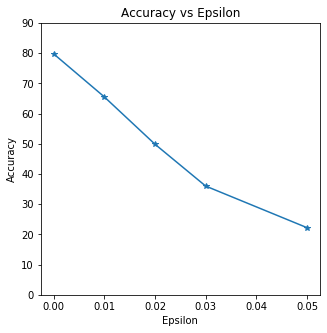

In [13]:
print('Projected Gradient Descent')

plt.figure(figsize=(5, 5))
plt.plot(epsilons, pgd_accuracies, '*-')
plt.yticks(np.arange(0, 100, step=10))
plt.xticks(np.arange(0, .06, step=0.01))
plt.title('Accuracy vs Epsilon')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
plt.show()

Projected Gradient Descent


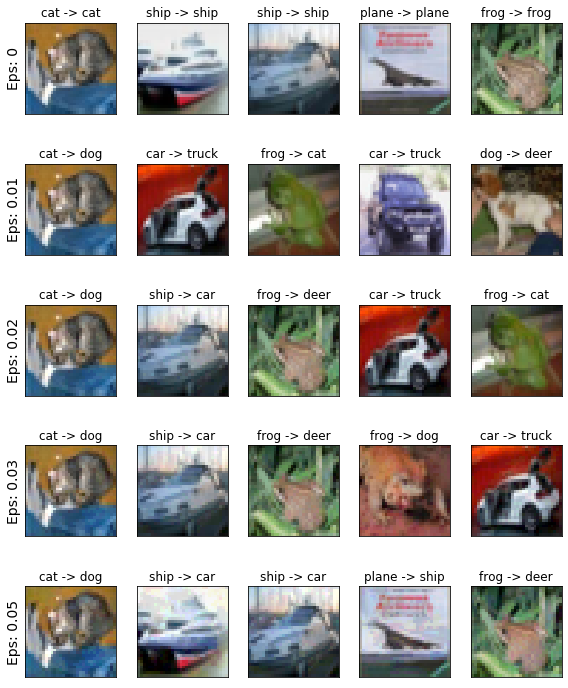

In [14]:
print('Projected Gradient Descent')

cnt = 0
plt.figure(figsize=(8, 10))
for i, eps in enumerate(epsilons):
    for j, exmps in enumerate(pgd_examples[i]):
        cnt += 1
        plt.subplot(len(epsilons), len(pgd_examples[0]), cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel('Eps: {}'.format(eps), fontsize=14)
        orig, adv, ex = exmps
        plt.title("{} -> {}".format(classes[orig], classes[adv]))
        plt.imshow(np.rollaxis(ex,0,3))
plt.tight_layout()
plt.show()